In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn import neighbors
from sklearn.metrics import auc, roc_curve, accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Introduction

We use this white wine quality dataset, and all of its attributes (e.g. sulfur dioxide content, pH) to determine what constitutes a "good" (or above average) quality wine. We used the R statistical computing language to conduct the analyses in this report. The data were found on the UC Irvine Machine Learning Repository.

Knowing what makes a good wine was an interesting question because it allows us to look at "taste" in a different way--without formal training in wine tasting, we can determine algorithmically how and why a wine is good using machine learning. 

We utilized random forest, decision trees, and k-nearest neighbors to classify each observation as either good or bad based off of these attributes, while varying the number of variables, nodes, and number of neighbors and comparing within and between these methods.  

In this report, we find the accuracy, error rates, and area under the ROC curve (AUC) of each of the three methods and ultimately came to determine that k-nearest neighbors (kNN) was the most effective in terms of both accuracy and AUC relative to the other algorithms.

In [3]:
# reading in the data
# pandas is loaded as pd
df = pd.read_csv("winequality-white.csv", sep = ";")
print(df.isnull().head()) # check for missing values

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          False             False        False           False      False   
1          False             False        False           False      False   
2          False             False        False           False      False   
3          False             False        False           False      False   
4          False             False        False           False      False   

   free sulfur dioxide  total sulfur dioxide  density     pH  sulphates  \
0                False                 False    False  False      False   
1                False                 False    False  False      False   
2                False                 False    False  False      False   
3                False                 False    False  False      False   
4                False                 False    False  False      False   

   alcohol  quality  
0    False    False  
1    False    False  
2    False    

A preliminary look at the dataset reveals that there are no missing values.

First we can look at the correlation matrix of the dataset, to see if any predictors are highly correlated with one another. We may have to take out these predictors in order to avoid multicollinearity, which can invalidate results. Having said this, multicollinearity is less of an issue with decision trees, and even less so with random forest, both of which are going to be used in this analysis. 

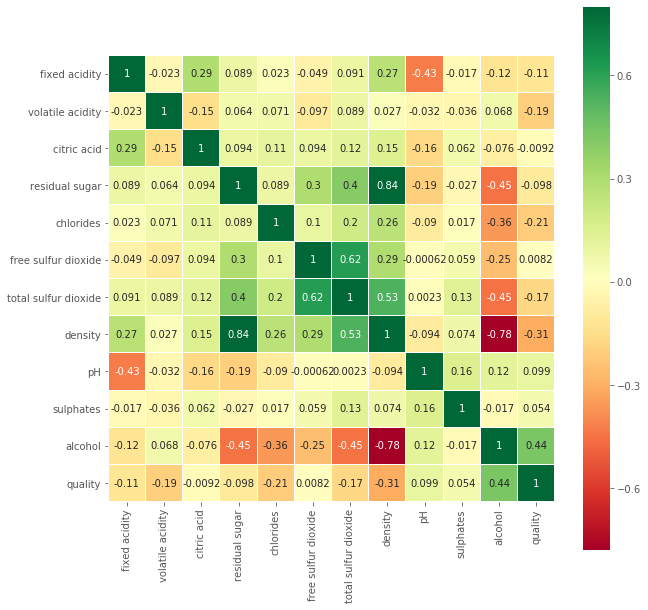

In [4]:
corr = df.corr() 
# import seaborn as sns
plt.figure(figsize = (10,10))
sns.heatmap(corr, vmax = .8, linewidths = 0.01, square = True, annot = True, cmap = 'RdYlGn', linecolor = 'white')
plt.show()

Taking a look at the correlation coefficients $r$ for the predictor variables, we see that `density` is strongly correlated with `residual.sugar` ($r = 0.84$) and `alcohol` ($r = -0.78$), and moderately correlated with `total.sulfur.dioxide` ($r = 0.53$). `free.sulfur.dioxide` and `total.sulfur.dioxide` are also moderately correlated with each other ($r = 0.62$) although this is trivially known because of course, free sulfur dioxide is incorporated into the total sulfur dioxide. 

Aside from that correlations are all very low, including (and especially) `quality`, the response variable, with the predictors. 

So, we should actually remove the variables `residual.sugar` and `density`, as well as `total.sulfur.dioxide` because if its direct relationship with `free.sulfur.dioxide`, in order to address problems with multicollinearity. We're going to withhold removing `alcohol`, to see the if the initial effect of removing just these three correlated variables is enough to address the issue. 

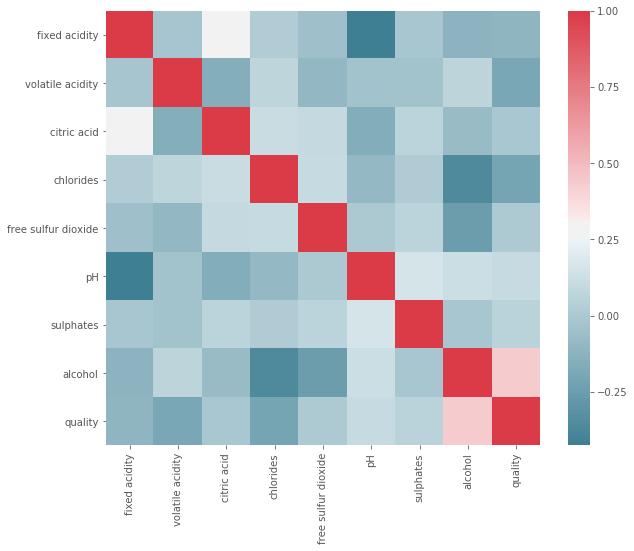

In [5]:
# removing three predictors
df = pd.read_csv("winequality-white.csv", sep = ";")
df.drop(["residual sugar", "density", "total sulfur dioxide"], axis = 1, inplace = True)

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
# seaborn is loaded as sns
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

From the new correlation matrix it appears that none of the predictors now have too high or a correlation with each other, and we can decide that multicollinearity is no longer an issue. 

From here on out, we're also going to want to convert the `quality` response variable into a binary factor so that we can use the predictors to classify the observations. We're going to do this by labeling all of the observations that have received an above average (5 out of 10) as "good", and the rest as "bad", "bad" really meaning "not good". This factor of `good` and `bad` goes under a new column titled `label`.

We'll remove the `quality` variable afterwards, since if we use it as an attribute in the predictor, it will skew the results because it is directly correlated to the label.

In [6]:
# assigning the independent  variables to X
X = df.loc[:, 'fixed acidity':'alcohol']
feature_names = X.columns.values 

# converting the dependent variable from numeric to categorical
def score_to_label(x):
    if x > 5:
        return 1
    else:
        return 0
        
# replacing the numeric 'quality' with categorical 'label'
df.quality = df.quality.apply(score_to_label)
df.quality, class_names = pd.factorize(df.quality)
y = df.quality

Now we have 8 numeric predictor variables, and one two-level categorical variable (`quality`), where 1 denotes 'good' and 0 denotes 'bad'. We're going to apply a few different classification methods in order to firstly determine which the best model for predicting is in terms of the relevant variables, and secondly to find the best classification algorithm for this data. The algorithms we are going to use are the decision tree, k-nearest neighbors, and random forest.

In order to apply machine learning algorithms to this dataset, we need to stratify the dataset into a training set and a test set. The first set will be used to teach the classification model how to predict, depending on the algorithm chosen. We then apply the algorithm to the test set, and see how accurate the classification was. 

It's important to note that all of these numeric predictor variables (`fixed.acidity`, `volatile.acidity`, `citric.acid`, `chlorides`, `free.sulfur.dioxide`, `pH`, `sulphates`, `alcohol`) are not all scaled the same. As such, it's appropriate to scale them before running any analyses. 

In [7]:
# split the data intro training and test sets, test size is 30% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

# scaling the numeric attributes
# from sklearn.preprocessingimport StandardScaler
scaler = StandardScaler().fit(X_train)
# scaled X
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

## Decision Tree

The first method we are going to perform on this dataset, is Decision Trees. Decision tree is a non-parametric classification method, which uses a set of rules to predict that each observation belongs to the most commonly occurring class label of training data. 

Of course, we're going to use `quality` as a response variable, and each of the now 8 remaining numeric attributes as predictors. Now we're going to fit the model, and then display a feature importance plot (also known as a variable importance plot) to see which features of the data were the most crucial to the model's prediction.

571
fixed acidity          0.081006
volatile acidity       0.126027
citric acid            0.109584
chlorides              0.115027
free sulfur dioxide    0.140644
pH                     0.114771
sulphates              0.096472
alcohol                0.216469
dtype: float64


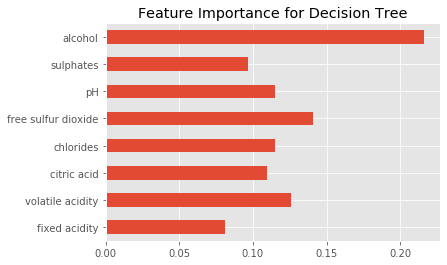

In [8]:
# from sklearn.tree import DecisionTreeClassifier
tree_clf = tree.DecisionTreeClassifier(random_state = 100)
tree_clf.fit(X_train, y_train) # training the model
tree_y_pred = tree_clf.predict(X_test)
print(tree_clf.tree_.n_leaves)
# Getting feature importances from model
tree_importance = pd.Series(tree_clf.feature_importances_, index = df.columns[0:8])
tree_importance.plot(kind = 'barh', title = 'Feature Importance for Decision Tree')
print(tree_importance)
plt.show()

As we can see, `alcohol` is far and away the most 'important' feature in the model, which gives us evidence towards the idea that it is important in differentiating between a 'good' and a 'bad' wine. We should note however that the tree has as many as 571 leaves, which is a massively complex model. 

Now we want to calculate the accuracy and error rate of the model. 

In [9]:
# numpy is loaded as np
# from sklearn.metrics import accuracy_score
tree_acc = accuracy_score(y_test, tree_y_pred)
print(tree_acc)

0.7761904761904762


With an accuracy rate of `0.776`, this decision tree model is not superb, but will still classify correctly about 3 out of 4 times. 

As an alternative metric to quantify the robustness of this method, we can use the Receiver Operating Characteristic (ROC) curve and the area underneath it (AUC). The ROC curve plots the false positive rate against the true positive rate, and the area underneath it falls between either 0.5 or 1, 0.5 being the worst (random classification), and 1 being the best (perfect classification). 

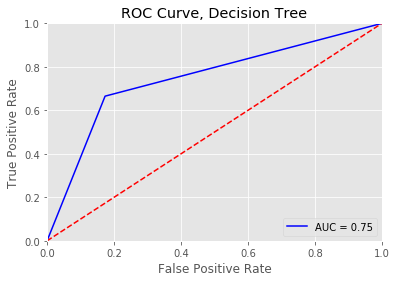

In [10]:
def calculate_roc(clf, X_test, y_test):
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    return roc_auc

# sklearn.metrics is loaded
def plot_roc_curve(clf, X_test, y_test, name):
    # calculating fpr, tpr and AUC
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    # plotting
    title = 'ROC Curve, ' + name
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

tree_roc = calculate_roc(tree_clf, X_test, y_test)
plot_roc_curve(tree_clf, X_test, y_test, "Decision Tree")

We see thusly that the area under the curve is $0.75$ which is exactly in between 1 and 0.5, which makes a moderately robust model.

### Pruning

One of the pitfalls of the decision tree model is that the more complex it is, the more prone it is to overfitting. We can control for this by playing with the parameters of the model, such as depth in this case. We can compare a variety of depths for the decision tree in order to determine an 'optimal' size of the tree that minimizes overfitting and maximizes accuracy and AUC. 

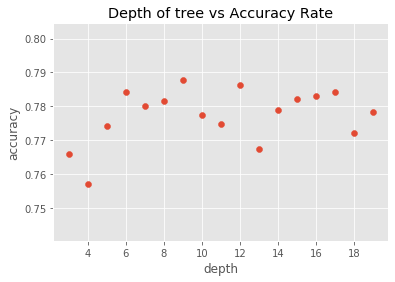

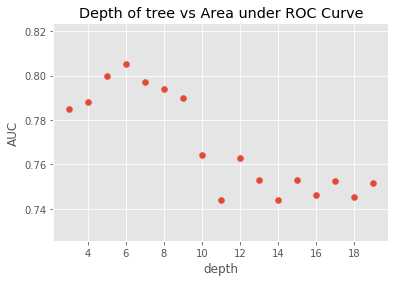

In [11]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

depth = []

for i in range(3,20):
    test_clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = i)
    test_clf.fit(X_train, y_train) # training the model
    test_y_pred = test_clf.predict(X_test) # making predictions
    accuracy = accuracy_score(y_test, test_y_pred)
    test_roc = calculate_roc(test_clf, X_test, y_test)
    depth.append((i, accuracy, test_roc))

# Comparing number of leaves to misclassification error
depth = pd.DataFrame(depth)
depth.columns = ['depth', 'accuracy', 'AUC']

# plotting
def scatter_plot(df, x, y, title):
    # matplotlib is loaded as plt
    plt.scatter(df[x], df[y])
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

scatter_plot(depth, 'depth', 'accuracy', 'Depth of tree vs Accuracy Rate')
scatter_plot(depth, 'depth', 'AUC', 'Depth of tree vs Area under ROC Curve')

We can see that a depth of 6 on the tree maximizes accuracy the area under the ROC curve, while keeping relatively close in accuracy with higher and lower depths. For example, while a tree with a depth of 12 has a similarly high accuracy rate, it has a much worse AUC. We can now fit a smaller decision tree model using a depth of 6 as suggested.

fixed acidity          0.039926
volatile acidity       0.212175
citric acid            0.036643
chlorides              0.043186
free sulfur dioxide    0.095806
pH                     0.081268
sulphates              0.037291
alcohol                0.453705
dtype: float64


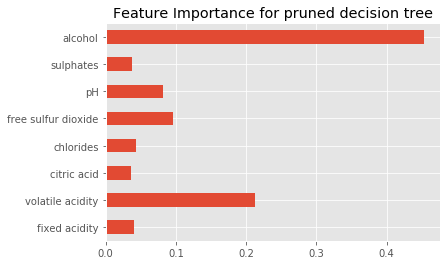

In [12]:
# the optimal number of leaves is 6
pruned_clf = tree.DecisionTreeClassifier(max_depth = 6)
pruned_clf.fit(X_train, y_train)
pruned_y_pred = pruned_clf.predict(X_test)
# variable importance plot
pruned_importance = pd.Series(pruned_clf.feature_importances_, index = df.columns[0:8])
print(pruned_importance)
pruned_importance.plot(kind = 'barh', title = 'Feature Importance for pruned decision tree')
plt.show()

Note that in this model, the importance of `alcohol` is even more exaggerated, and likewise for `volatile.acidity`. `sulfur.dioxide` is still the 3rd most important, but it is not that far off from the other variables.

Now we can apply the same diagnostic methods as before: looking at the accuracy rate, the ROC curve and the area underneath it, for the sake of comparison. 

In [13]:
pruned_acc = accuracy_score(y_test, pruned_y_pred)
print(pruned_acc)

0.7843537414965986


We see that pruning the tree only marginally improved the accuracy rate of the model, although it did condense the number of relevant variables. It does however emphasize the importance of those 3 crucial features of the data when it comes to predicting. We have also managed to create a model that is less prone to overfitting without losing any accuracy. Complex models run the risk of over-fitting, which is to say that the data follows the training data too closely and cannot be well generalized to new data. This is why we are inclined to favor a simpler model such as that we found after pruning.

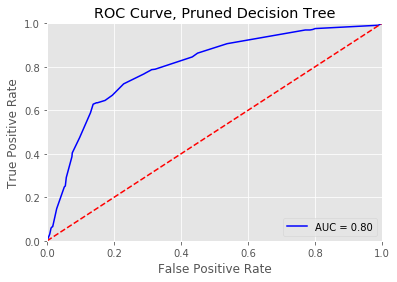

In [14]:
pruned_roc = calculate_roc(pruned_clf, X_test, y_test)
plot_roc_curve(pruned_clf, X_test, y_test, "Pruned Decision Tree")

The smaller decision tree happened to improve on the area under the ROC curve slightly. This is great because our model is more robust and also less complex and therefore less prone to overfitting.

## k-Nearest Neighbors (kNN)

We're now going to apply the k-nearest neighbors method of classification, which is a non-parametric method.  k-Nearest neighbors (or kNN) is called a "lazy learning" technique because it goes through the training set every time it predicts a test sample's label. It finds this label by plotting the test sample in the same dimensional space as the training data, then classifies it based on the "k nearest neighbor(s)", i.e. if k = 10, then the label of the 10 nearest neighbors in the training data to the test data observation will be applied to that observation.

Distance is measured in different ways, but by default the `knn()` function utilized Euclidean distance. 

This is rather problematic because when calculating distance it's assumed that attributes have the same effect, while this is not generally true. So the distance metric (Euclidean distance in this case) does not take into account the attributes' relationships with each other, which can result in misclassification. So already we have determined a shortcoming in the kNN method before we have even applied it. Although of course, we already dropped the predictors that were highly correlated with each other, and what's more we scaled the remaining numeric predictors, which goes in a small way to addressing this.

In [15]:
# k-nearest neighbors
knn_clf = neighbors.KNeighborsClassifier(10, weights = "distance")
knn_clf.fit(X_train, y_train)
knn_y_pred = knn_clf.predict(X_test)

# metrics and ROC curve
knn_acc = accuracy_score(y_test, knn_y_pred)
print(knn_acc)

0.8353741496598639


So, using 10 nearest neighbors was just a random estimate, and it ended up with another mediocre accuracy rate ($0.835$) but we can look at the area under the ROC curve (AUC) and look at the strength of the test relative to the methods we have tried so far. 

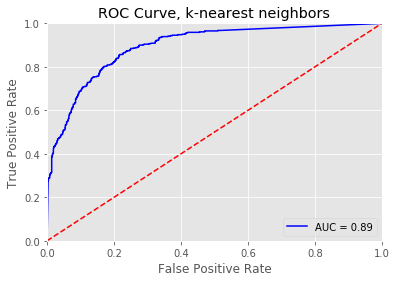

In [16]:
knn_roc = calculate_roc(knn_clf, X_test, y_test)
plot_roc_curve(knn_clf, X_test, y_test, "k-nearest neighbors")

So with an AUC of $0.89$, this model has shown itself to be the most robust test thus far. We can look at other values for `k` and see if other values improve on the model. 

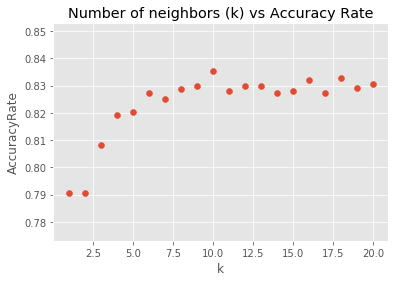

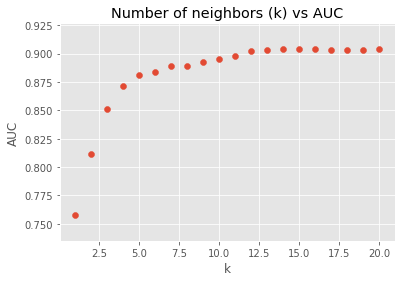

In [17]:
knn_df = []
for k in range(1,21):
    # fitting and using the knn classifier
    test_clf_knn = neighbors.KNeighborsClassifier(n_neighbors = k, weights = "distance") # creating the classifier
    test_clf_knn.fit(X_train, y_train) # fitting the classifier
    test_knn_pred = test_clf_knn.predict(X_test) # predicting with the test set

    # Calculate AUC
    test_roc_auc = calculate_roc(test_clf_knn, X_test, y_test)

    knn_df.append({'k': k,
               'AccuracyRate': accuracy_score(y_test, test_knn_pred),
               'AUC': test_roc_auc})

knn_df = pd.DataFrame(knn_df)
# plotting
scatter_plot(knn_df, 'k', 'AccuracyRate', 'Number of neighbors (k) vs Accuracy Rate')
scatter_plot(knn_df, 'k', 'AUC', 'Number of neighbors (k) vs AUC')

`k=10` happens to maximize accuracy, while also keeping relatively in line with the AUC metric in comparison to similar values. It seems in general the test becomes more robust the higher the value of `k`, but the accuracy and AUC seem to plateau after a certain point. As always we would like to refrain from having an overly complex model so we opt to stick with our k = 10. 

Finally we can move on to the final method of classification, the random forest algorithm.

## Random Forest

Random forest is similar to the decision tree method in that it builds trees, hence the name 'random forest'. This is an ensemble learning method which creates a multitude of decision trees, and outputting the class that occurs most frequently among them. The advantage that random forest has over decision trees is the element of randomness which guards against the pitfall of overfitting that decision trees run into on their own. The disadvantage however is that since it is a 'black-box' algorithm, it is harder to interpret than a decision tree. 

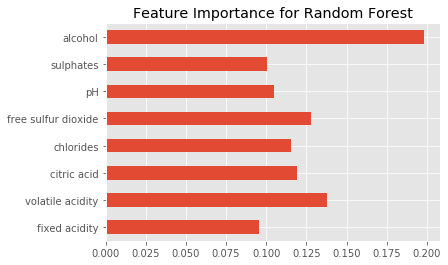

In [18]:
# random forest
rf_clf = RandomForestClassifier(bootstrap = True, random_state = 100)
rf_clf.fit(X_train, y_train)

# Getting feature importances from model
rf_importance = pd.Series(rf_clf.feature_importances_, index = df.columns[0:8])
rf_importance.plot(kind = 'barh', title = 'Feature Importance for Random Forest')
plt.show()

In this random forest model, it seems that the other features are much more emphasized relative to `alcohol` than they were previously, although alcohol is definitely still the front-runner. We can now look at if the model has made improvements in accuracy or AUC over the other models.

In [19]:
rf_y_pred = rf_clf.predict(X_test)

# metrics and plotting ROC curve
rf_acc = accuracy_score(y_test, rf_y_pred)
print(rf_acc)

0.8197278911564626


With an accuracy rate of `0.834`, this random forest model is looking pretty good and is comparable to the k-nearest neighbors algorithm.

Let's take a look at the ROC curve and the area underneath it. 

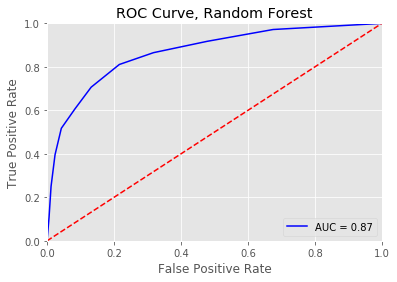

In [20]:
rf_roc = calculate_roc(rf_clf, X_test, y_test)
plot_roc_curve(rf_clf, X_test, y_test, "Random Forest")

The area under the ROC curve for random forest is `0.88`, which is also a strong AUC for a classification model and again it is pretty similar to that of the k-nearest neighbors model we fit earlier. The random forest algorithm also brings with it bootstrapping aggregation, which makes it less susceptible to overfitting than other classification algorithms. It does unfortunately suffer from an increased level of complexity as a result. 


In [21]:
records = []
algos = ('decision tree', 'pruned decision tree', 'k-Nearest Neighbors', 'Random Forest')
accuracy_rates = (tree_acc, pruned_acc, knn_acc, rf_acc)
aucs = (tree_roc, pruned_roc, knn_roc, rf_roc)

for i in range(0,4):
  records.append({'Algorithm': algos[i], 
                  'Accuracy Rate': accuracy_rates[i], 
                  'AUC': aucs[i]})

# converting into a dataFrame
records = pd.DataFrame(records)
records = records[['Algorithm', 'Accuracy Rate', 'AUC']]

print(records)

              Algorithm  Accuracy Rate       AUC
0         decision tree       0.776190  0.745975
1  pruned decision tree       0.784354  0.803551
2   k-Nearest Neighbors       0.835374  0.894978
3         Random Forest       0.819728  0.867022


# Conclusion

So judging from all of our findings, we have seen that in this case, k-nearest neighbors is the best algorithm (out of the three we've compared) for classifying this wine dataset. So we have answered the question of what among these three classification algorithms is truly the best. In this case, k-nearest neighbors had the highest accuracy rate and the highest AUC, although it was followed shortly by the random forest model.

The decision tree algorithm is useful but ultimately, random forest is superior version of it since it aggregates many decision trees to create an optimized model that is not susceptible to overfitting. When it comes to interpretability however, a decision tree is preferred. When using a decision tree however it is important to prune the tree in order to prevent overfitting to the training data. 

We did find by looking at variable importance that `alcohol`, `volatile.acidity`, and `free.sulfur.dioxide` are the most consistently important features in the data, and this was mostly corroborated by the decision tree and k-nearest neighbor models. 

As far as what these variables' importance is in reality, is that sulfur dioxide is crucial for killing bacteria in wine when creating it. On the other hand, volatile acidity is an undesired trait in wine that affects flavor, that can be caused by such bacteria. So it makes sense that wine that is high in sulfur dioxide, and low in volatile acidity, is considered good. 

The pending questions that remain are, did we overfit or underfit to the training data when testing these different classification methods? It is also worth determining exactly the threshold for the amounts of these variables such as `alcohol`, for example finding the optimal amount of alcohol content to create a good wine. 

We would also like to delve more into how best to select some $k$ for kNN that maintains a high level of accuracy while also having a balance between bias and variance without either over or underfitting. We would also posit a similar question for the number of nodes in a decision tree. Finally, is dropping variables in random forest really necessary, if the randomization inherent in it already accounts for overfitting?

In conclusion we have found that k-nearest neighbors is best for binary classification (in this case) and that alcohol, volatile acidity, and free sulfur dioxide are the most important predictors when attempting to classify a good wine.

# References

Tan, Pang-Ning, Michael Steinbach, and Vipin Kumar. Introduction To Data Mining. 1st ed. Addison Wesley: Pearson, 2005. Print.

Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Venables, W. N. & Ripley, B. D. (2002) Modern Applied Statistics with S. Fourth Edition. Springer, New
York. ISBN 0-387-95457-0